In [1]:
### cloning repositories
#!rmdir /s/q drone_data
!git clone https://github.com/anaguilarar/drone_data.git

Cloning into 'drone_data'...


In [1]:
#### import drone package
#### import drone package
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from drone_data.utils.classification_functions import cluster_4dxarray
from drone_data.utils.phenomics_functions import Phenomics, ts_plot, tsquantiles_plot
from drone_data.utils.plt_functions import plot_multitemporal_rgb, plot_multichanels
from drone_data.utils.multipolygons_functions import single_vi_bsl_impt_preprocessing

from drone_data.utils.gis_functions import get_filteredimage
from drone_data.utils.drone_data import calculate_vi_fromxarray
from drone_data.utils.xyz_functions import get_baseline_altitude
from drone_data.utils.xr_functions import filter_3Dxarray_contourarea

from drone_data.utils.multipolygons_functions import VEGETATION_INDEX

In [2]:

def from_long_towide(data, indexname, values_columnname, metrics_colname):

    widephenomycs = []
    for name in np.unique(data[metrics_colname].values):

        ssdata = data.loc[data[metrics_colname] == name]
        ssdatawide = ssdata.copy().reset_index()
        ssdatawide['idx'] = ssdatawide.groupby([indexname]).cumcount()
        ssdatawide['idx'] = np.unique(ssdatawide.metric.values) + '_t' + ssdatawide.idx.astype(str)
        
        widephenomycs.append(ssdatawide.pivot(
        index=indexname,columns='idx',values=values_columnname).reset_index())
    
    dfconcatenated = widephenomycs[0]
    for i in range(1,len(widephenomycs)):
        dfconcatenated = pd.merge(dfconcatenated,widephenomycs[i], how="left", on=[indexname])

    return dfconcatenated.reset_index()

### Config

In [3]:
SOILKMEANS = "F:/OneDrive - The University of Tokyo/drone_data/results/kmeans_cluster/tanashi/kmeans_5_vi_soil.pickle"
refindexes = ['blue','green','red',
              'blue_ms','green_ms','red_ms',
              'blue_eq','green_eq','red_eq',
              'nir','edge',
              'grvi', 'mgrvi','rgbvi','grvi_rgb','mgrvi_rgb', 'rgbvi_rgb', 'ndvi','savi', 'ndre', 'gndvi', 'reci','negvi', 'regnvi',
              ]



INPUTFOLDER = "F:/OneDrive - The University of Tokyo/drone_data/results/xarraydata/tanashi/per_polygon/rgb_ms_xyz_rgbreference_27tp/"
SHP_PATH =  "F:/OneDrive - The University of Tokyo/drone_data/results/tanashicropdetection/cc_od_polygons_yolodr5m_tana_ov_65conf_mn_tp.shp"
DATETODELETE = 4
DATESTOSELECT =  list(range(0,DATETODELETE)) + list(range(DATETODELETE+1,27))
SOILKMEANS = "F:/OneDrive - The University of Tokyo/drone_data/results/kmeans_cluster/tanashi/kmeans_5_vi_soil.pickle"
VILIST= ['grvi', 'mgrvi','rgbvi','grvi_rgb','mgrvi_rgb', 'rgbvi_rgb', 'ndvi','savi', 'ndre', 'gndvi', 'reci','negvi', 'regnvi']

IMAGEREDUCTION = 70


In [4]:
with open(SOILKMEANS, "rb") as f:
    kmeanmodel_soil = pickle.load( f)

### Individual plant imagery pre-processing

In [5]:
import matplotlib
#img = xrcluster.isel(date = cont).copy()
varnames = kmeanmodel_soil['variable_names']
#xrcluster = cluster_4dxarray(xrexample_dois[varnames].copy(), kmeanmodel_soil)['cluster']

#i = 888 # id_plant_668_rgbmspointcloud.pickle

xrfiles = os.listdir(INPUTFOLDER)
xrfiles = [i for i in xrfiles if i.endswith('pickle')]
xrfile = "id_plant_355_rgbmspointcloud.pickle"
print(xrfile)
with open(os.path.join(INPUTFOLDER,xrfile),"rb") as f:
    xrexample= pickle.load(f)

xrtestvi = xrexample.isel(date = DATESTOSELECT).copy()
xrtestdf = xrtestvi.isel(date = 0).to_dataframe()
altref = xrtestdf.reset_index().loc[:,('x','y','z','red_3d','green_3d','blue_3d')].dropna()
bsl = get_baseline_altitude(altref, method='max_probability')

for vi in VILIST:
    xrtestvi = calculate_vi_fromxarray(xrtestvi,vi = vi,expression = VEGETATION_INDEX[vi])

id_plant_355_rgbmspointcloud.pickle


### kmeans example

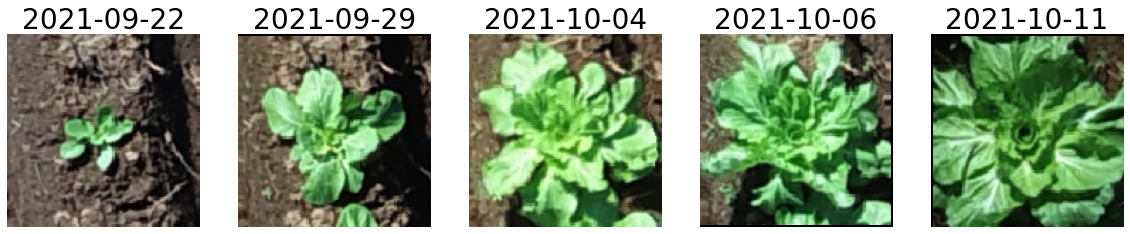

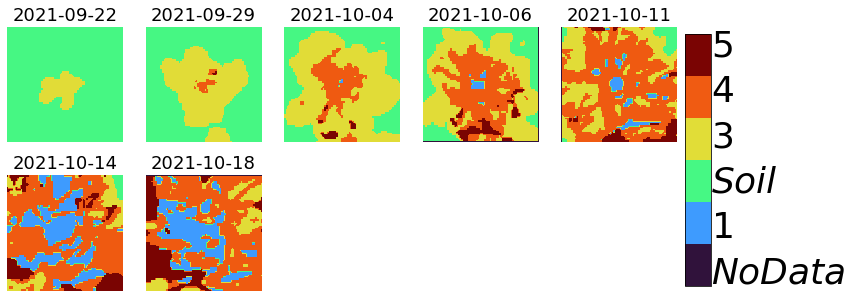

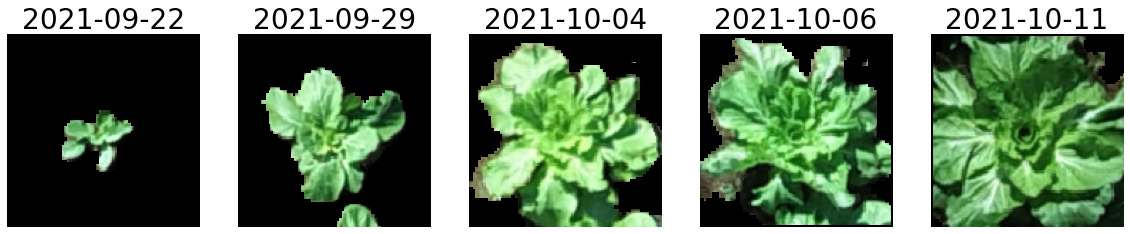

In [6]:

cmap = matplotlib.cm.get_cmap('turbo', (len(np.unique(kmeanmodel_soil['labels']))+1))

xrimage ,xrcluster = cluster_4dxarray(xrtestvi.copy(),cl_dict = kmeanmodel_soil, 
                                      cluster_value= kmeanmodel_soil['soil_cluster'], 
                                      only_thesedates=[0,1,2,3,4,5,6])


f1= plot_multitemporal_rgb(xrtestvi.isel(date = [0,1,2,3,4]),ncols=5, nrows=1, fontsize=28)
f1.savefig('../../../papers/chinese_cabbage_freshweigth_prediction/figures/figure_preprocessing/rgbbefore_2.jpg',
            dpi=600)

fig, ax = plot_multichanels(xrcluster.values, num_columns=5, num_rows=2, 
                            cmap = cmap, figsize=(12,5),
                            fontsize=18,
                            chanels_names=[np.datetime_as_string(i, unit='D') 
                                           for i in xrtestvi.date.values[[0,1,2,3,4,5,6]]],
                            legtickssize = 36,
                            newlegendticks = [
                                '$No Data$','$1$','$Soil$','$3$','$4$','$5$'])

#fig.savefig('../../../papers/chinese_cabbage_freshweigth_prediction/figures/figure_preprocessing/kmeansmask_7times_2.jpg',
#            dpi=1200)

f2= plot_multitemporal_rgb(xrimage.isel(date = [0,1,2,3,4]),ncols=5, nrows=1, fontsize=28)
f2.savefig('../../../papers/chinese_cabbage_freshweigth_prediction/figures/figure_preprocessing/rgbafter_2.jpg',
            dpi=600)
#cb.ax.tick_params(labelsize=15)
#fig.savefig('../../../papers/chinese_cabbage_freshweigth_prediction/figures/supporting/kmeansmask.jpg',dpi=1200)


### image reduction example


In [7]:
from drone_data.utils.image_functions import calculate_mask_contourarea
import cv2


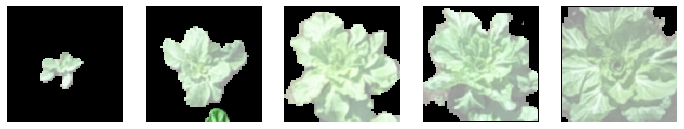

In [8]:
import copy 

fig, ax = plt.subplots(figsize=(12,8), ncols=5,
                               nrows=1)
for i in range(5):
    img = copy.deepcopy(xrimage.red.isel(date = i).values)
    channelimg = img.astype(np.uint8)
    channelimg[channelimg<0] = 0
    channelimg[channelimg>0] = 255
    threebanddata = []
    for z in ['red', 'green','blue']:
        threebanddata.append(xrimage.isel(date= i).copy()[z].data)
    threebanddata = np.dstack(tuple(threebanddata))/255

    maskarea = calculate_mask_contourarea(channelimg,threhold=0.7)
    maskarea = maskarea.astype(float)
    maskarea[maskarea == 0.] = np.nan
    ax[i].imshow(threebanddata)
    ax[i].imshow(maskarea, alpha = 0.6, vmin=1, cmap='gray')
    ax[i].invert_xaxis()
    ax[i].set_axis_off()

fig.savefig('../../../papers/chinese_cabbage_freshweigth_prediction/figures/figure_preprocessing/rgbafternoise_2.jpg',
            dpi=600)

### Hull and centering

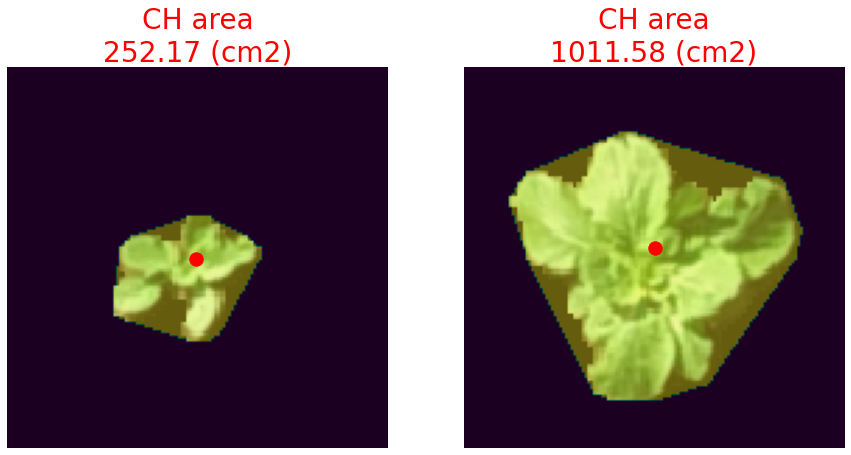

In [9]:
uavdatamasked_filt = filter_3Dxarray_contourarea(xrimage.copy())

convplotphen = Phenomics(uavdatamasked_filt.isel(date = [0,1]), filter_method= None, earlystages_filter=False)
convplotphen.convex_hull_plot(size = 180, alphahull=0.4, figsize=(15,15))

### image centering


(136, 136)
x 68 68 136
y 68 68 136
y 136 x 136


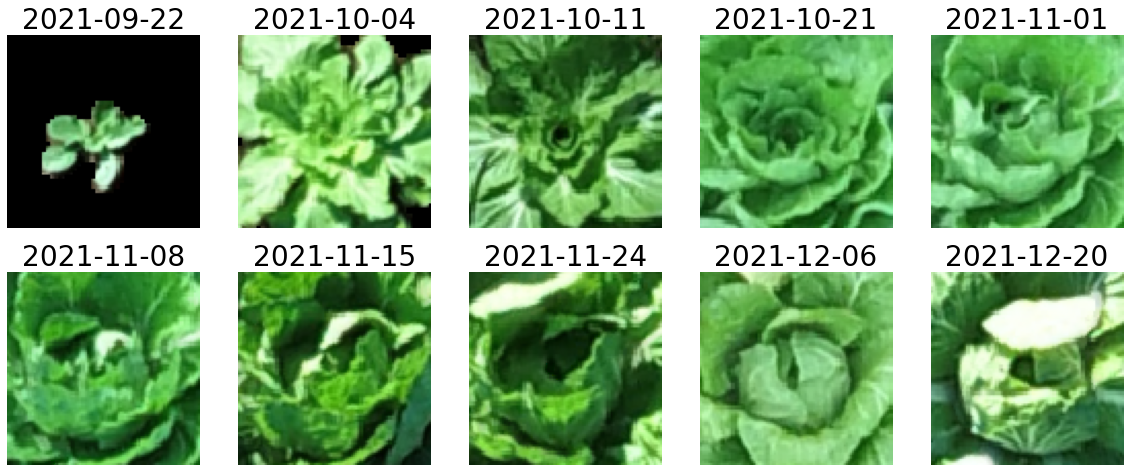

In [10]:
uavdatamasked_red = get_filteredimage(uavdatamasked_filt, 
                                    channel = 'red',
                                    red_perc = IMAGEREDUCTION, 
                                    refimg = 0, 
                                    clip_xarray=True,
                                    wrapper='hull')

f= plot_multitemporal_rgb(uavdatamasked_red.isel(date = [0,2,4,8,11,
                                                         14,17,20,23,25]),ncols=5, nrows= 2,
                          figsize=(20,8),
                          fontsize=28)
f.savefig('../../../papers/chinese_cabbage_freshweigth_prediction/figures/figure_preprocessing/imagecentered_2.jpg',
            dpi=600)

### Plant heigth plot

96.44199752807617


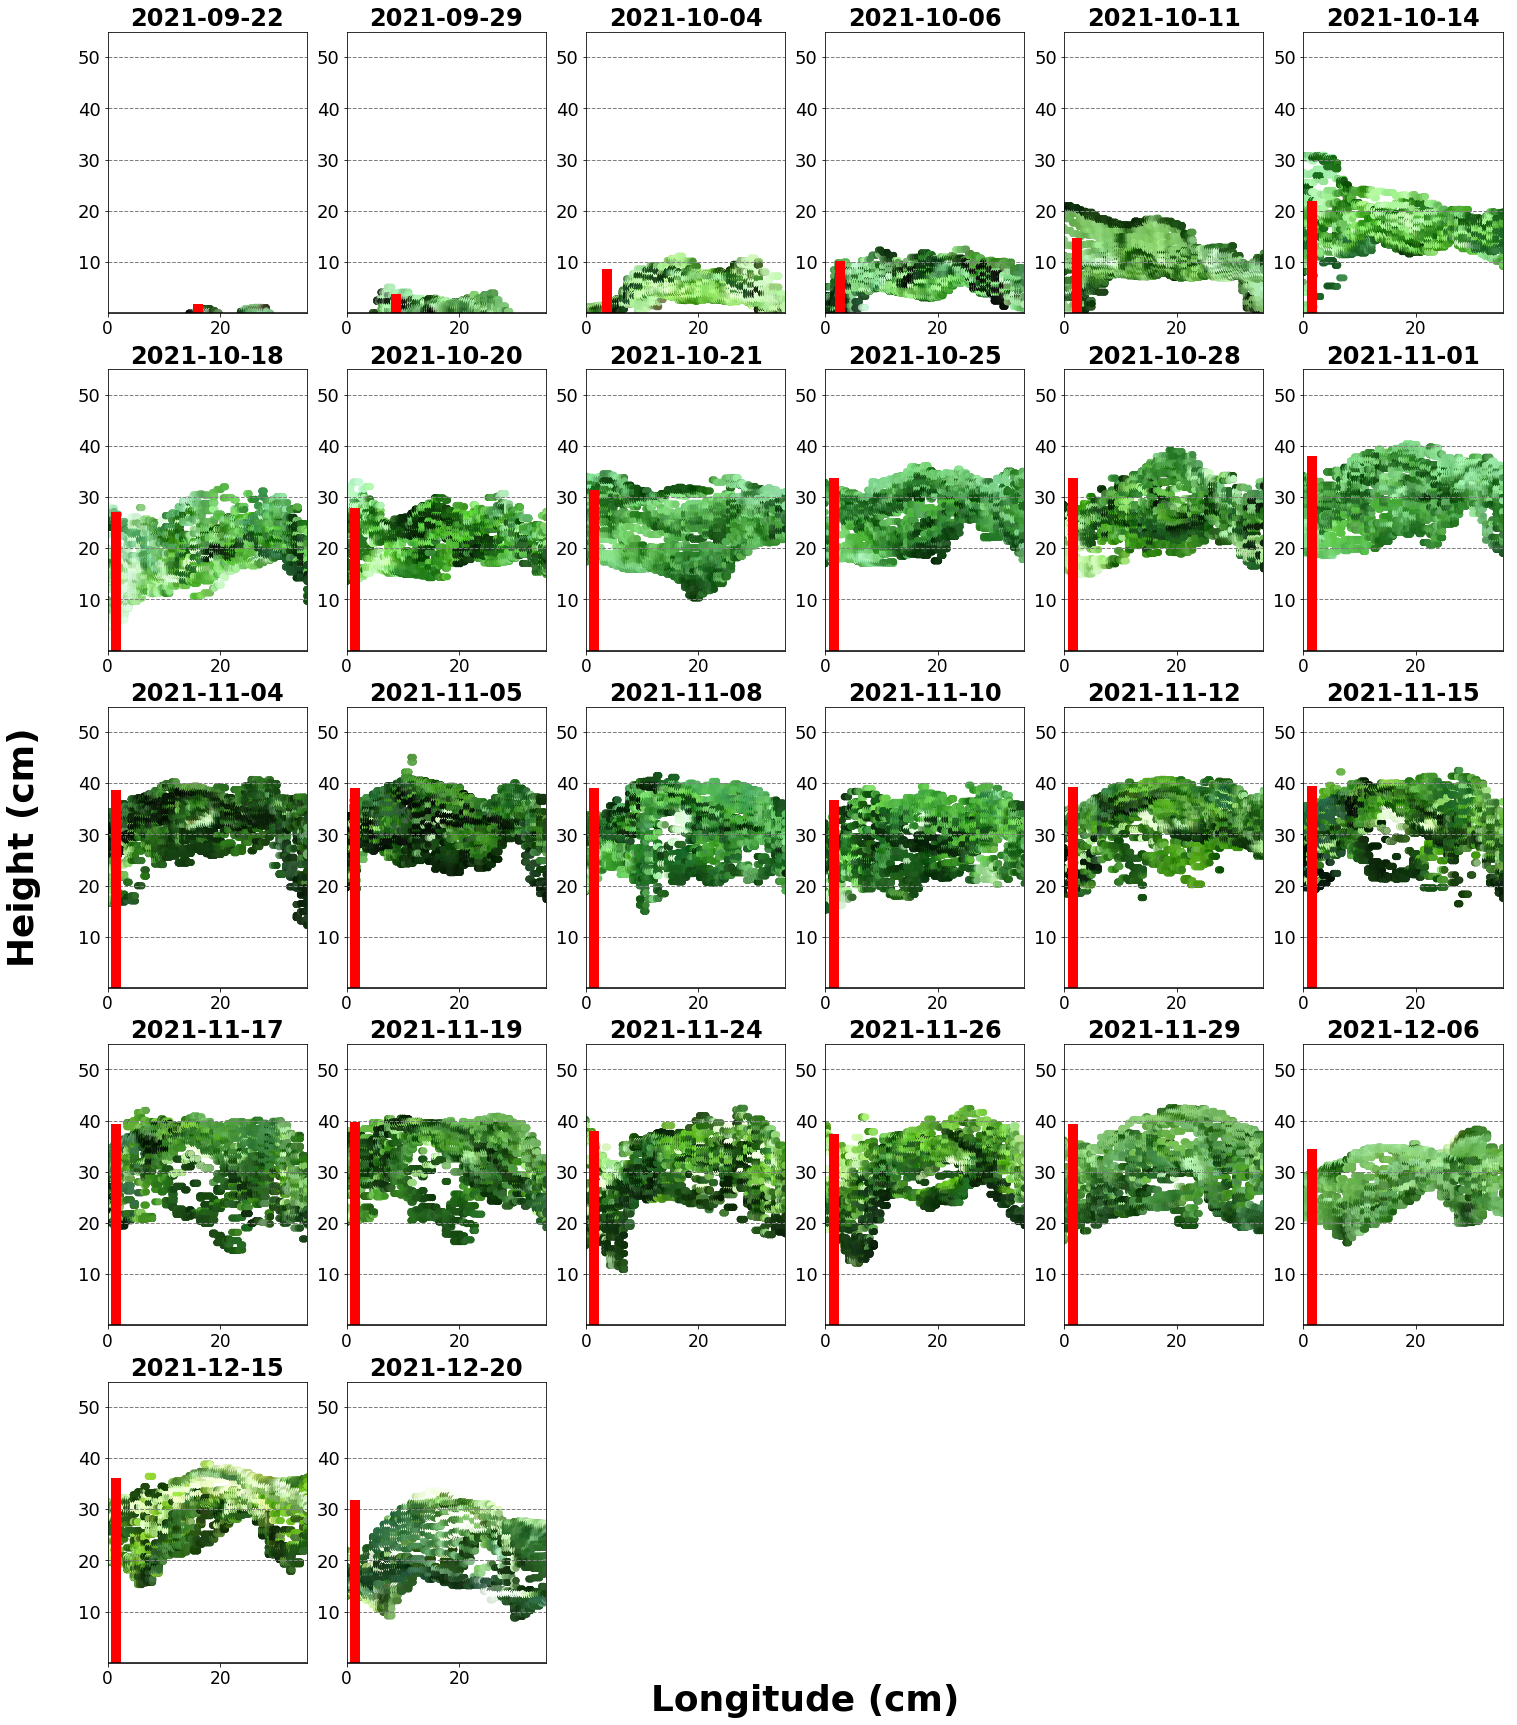

In [110]:
from drone_data.utils.plt_functions import plot_heights
xrtestdf = uavdatamasked_red.isel(date = 0).to_dataframe()
altref = xrtestdf.reset_index().loc[:,('x','y','z','red_3d','green_3d','blue_3d')].dropna()
bsl = get_baseline_altitude(altref, method='max_probability')
print(bsl)

f, ax = plot_heights(uavdatamasked_red, phquantile=0.9,  bsl = bsl, num_rows = 5, 
                     num_columns = 6, figsize=(25,30), fontsize= 24)

f.savefig('../../../papers/chinese_cabbage_freshweigth_prediction/figures/supporting/plant_height.jpg',
            dpi=600)

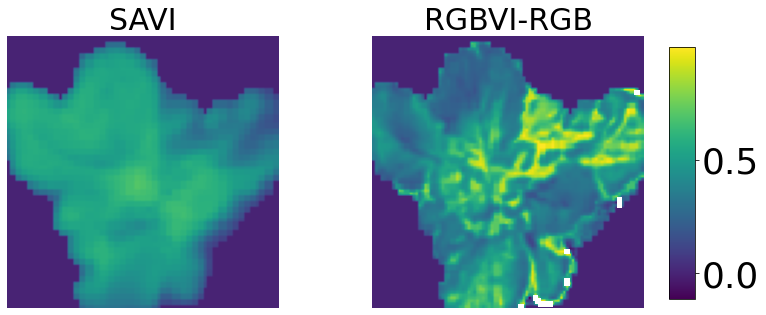

In [121]:
fig, ax = plot_multichanels(uavdatamasked_red[['savi','rgbvi_rgb']].isel(date = 1 ).to_array().values, num_columns=2, num_rows=1, 
                            #cmap = cmap, 
                            figsize=(12,5),
                            fontsize=30,
                            chanels_names=['SAVI', 'RGBVI-RGB'],
                            legtickssize = 36)

In [ ]:
nrows = 6
ncols = 5
fig, axs = plt.subplots(nrows, ncols,figsize=(12,14))
cont = 0
cmap = matplotlib.cm.get_cmap('turbo', (len(np.unique(kmeanmodel_soil['labels']))+1))
vmin = np.nanmin(xrclustersoil.cluster.values)
vmax = np.nanmax(xrclustersoil.cluster.values)
for xi in range(nrows):
    for yi in range(ncols):
        if cont < len(xrclustersoil.date.values):
            img = xrclustersoil.isel(date = cont).copy().cluster.values

            if nrows>1:
                #dataimg = xrtest.isel(date=cont).copy()
                
                #img = img.where(img != 2, np.nan)
                im = axs[xi,yi].imshow(img, cmap = cmap, vmin=vmin, vmax=vmax)
                axs[xi,yi].set_axis_off()
                axs[xi,yi].set_title(np.datetime_as_string(xrclustersoil.date.values[cont], unit='D'), fontsize=16)
                axs[xi,yi].invert_xaxis()
                cont+=1
            else:
                im = axs[yi].imshow(img, cmap = cmap, vmin=vmin, vmax=vmax)
                axs[yi].set_axis_off()
                axs[yi].set_title('{}'.format(np.datetime_as_string(xrclustersoil.date.values[cont], unit='D')), fontsize=20)
                axs[yi].invert_xaxis()
                cont+=1

        else:
            axs[xi,yi].axis('off')

cbar_ax = fig.add_axes([0.91, 0.35, 0.03, 0.3])
#cbar_ax = fig.add_axes([0.91, 0.15, 0.03, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
#cb.ax.tick_params(labelsize=15)

for j, lab in enumerate(['$No Data$','$1$','$2$','$Soil$','$4$','$5$','$6$','$7$']):
    cb.ax.text(8, (7.2 * j + 2) / 8.0, lab, ha='left', va='center',fontsize=18)

cb.ax.get_yaxis().labelpad = 15

### Feature computation

id_plant_355_rgbmspointcloud.pickle
96.41408920288086
(136, 136)
x 68 68 136
y 68 68 136
y 136 x 136


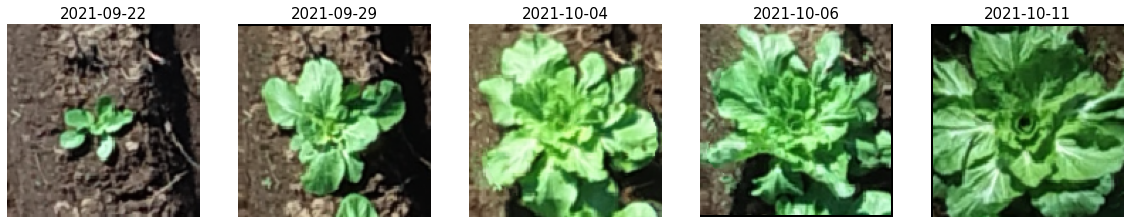

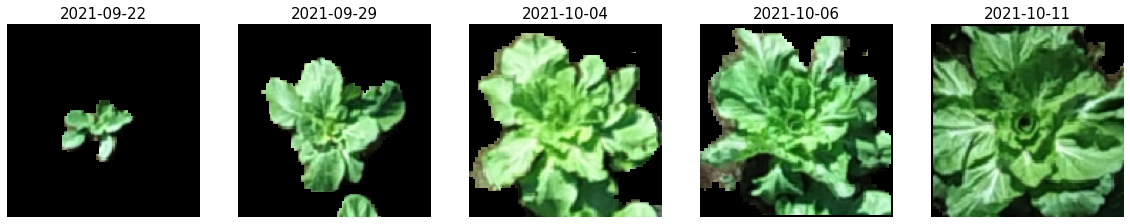

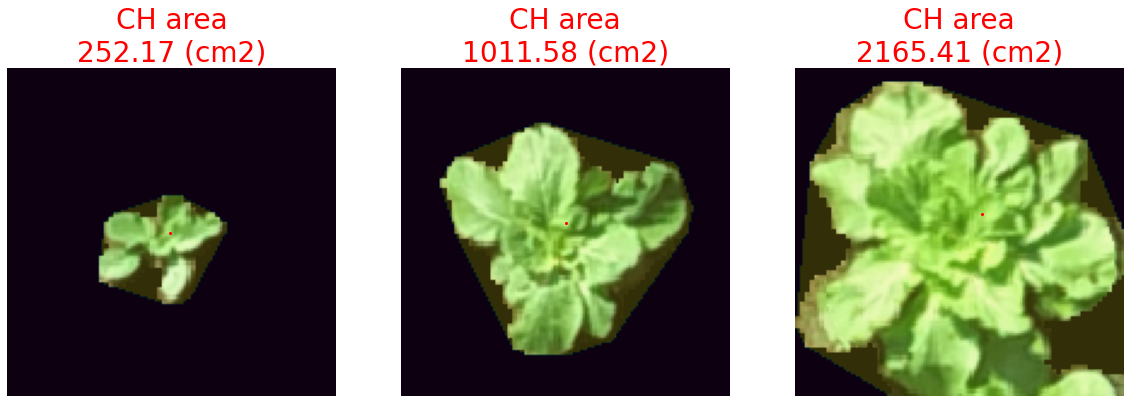

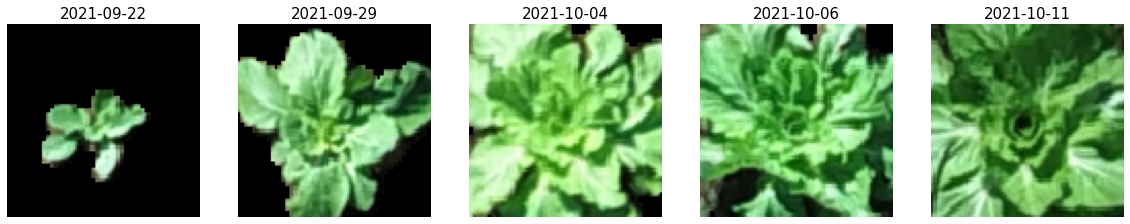

In [9]:

from drone_data.utils.multipolygons_functions import VEGETATION_INDEX
## reading a single indvidual plant imagery as example

xrfiles = os.listdir(INPUTFOLDER)
xrfiles = [i for i in xrfiles if i.endswith('pickle')]

#i = 1092 #id_plant_945_rgbmspointcloud.pickle
#i = 786 # id_plant_668_rgbmspointcloud.pickle
i = 750
i = 288
#i = 92 # small
i=2
#i = 666 #check
#i = 888

i = 444
#i = 555
xrfile = "id_plant_1_rgbmspointcloud.pickle"
xrfile = xrfiles[i]
print(xrfile)
with open(os.path.join(INPUTFOLDER,xrfile),"rb") as f:
    xrexample= pickle.load(f)


xrtestvi = xrexample.isel(date = DATESTOSELECT).copy()
f= plot_multitemporal_rgb(xrtestvi.isel(date = [0,1,2,3,4]),ncols=5, nrows= 1)


xrtestdf = xrtestvi.isel(date = 0).to_dataframe()
altref = xrtestdf.reset_index().loc[:,('x','y','z','red_3d','green_3d','blue_3d')].dropna()
bsl = get_baseline_altitude(altref, method='max_probability')
print(bsl)
for vi in VILIST:
    xrtestvi = calculate_vi_fromxarray(xrtestvi,vi = vi,expression = VEGETATION_INDEX[vi])

### cluster
clvalue = kmeanmodel_soil["soil_cluster"]

xrmasked,_ = cluster_4dxarray(xrtestvi, kmeanmodel_soil, cluster_value=clvalue, only_thesedates=[0,1,2,3,4,5,6])

f= plot_multitemporal_rgb(xrmasked.isel(date = [0,1,2,3,4]),ncols=5, nrows= 1)

uavdatamasked_filt = filter_3Dxarray_contourarea(xrmasked.copy())


xrafterpre,suffixd = single_vi_bsl_impt_preprocessing(
                            uavdatamasked_filt.copy(), 
                            vilist=None,
                            baseline=True,
                            imputation= False,
                            bsl_value = bsl)
convplotphen = Phenomics(xrafterpre.isel(date = [0,1,2]), filter_method= None, earlystages_filter=False)
convplotphen.convex_hull_plot(size = 4)

#f= plot_multitemporal_rgb(xrexample, ncols = 5, figsize= (8,8))
uavdatamasked_red = get_filteredimage(xrafterpre, 
                                    channel = 'red',
                                    red_perc = IMAGEREDUCTION, 
                                    refimg = 0, 
                                    clip_xarray=True,
                                    wrapper='hull')

f= plot_multitemporal_rgb(uavdatamasked_red.isel(date = [0,1,2,3,4]),ncols=5, nrows= 1)


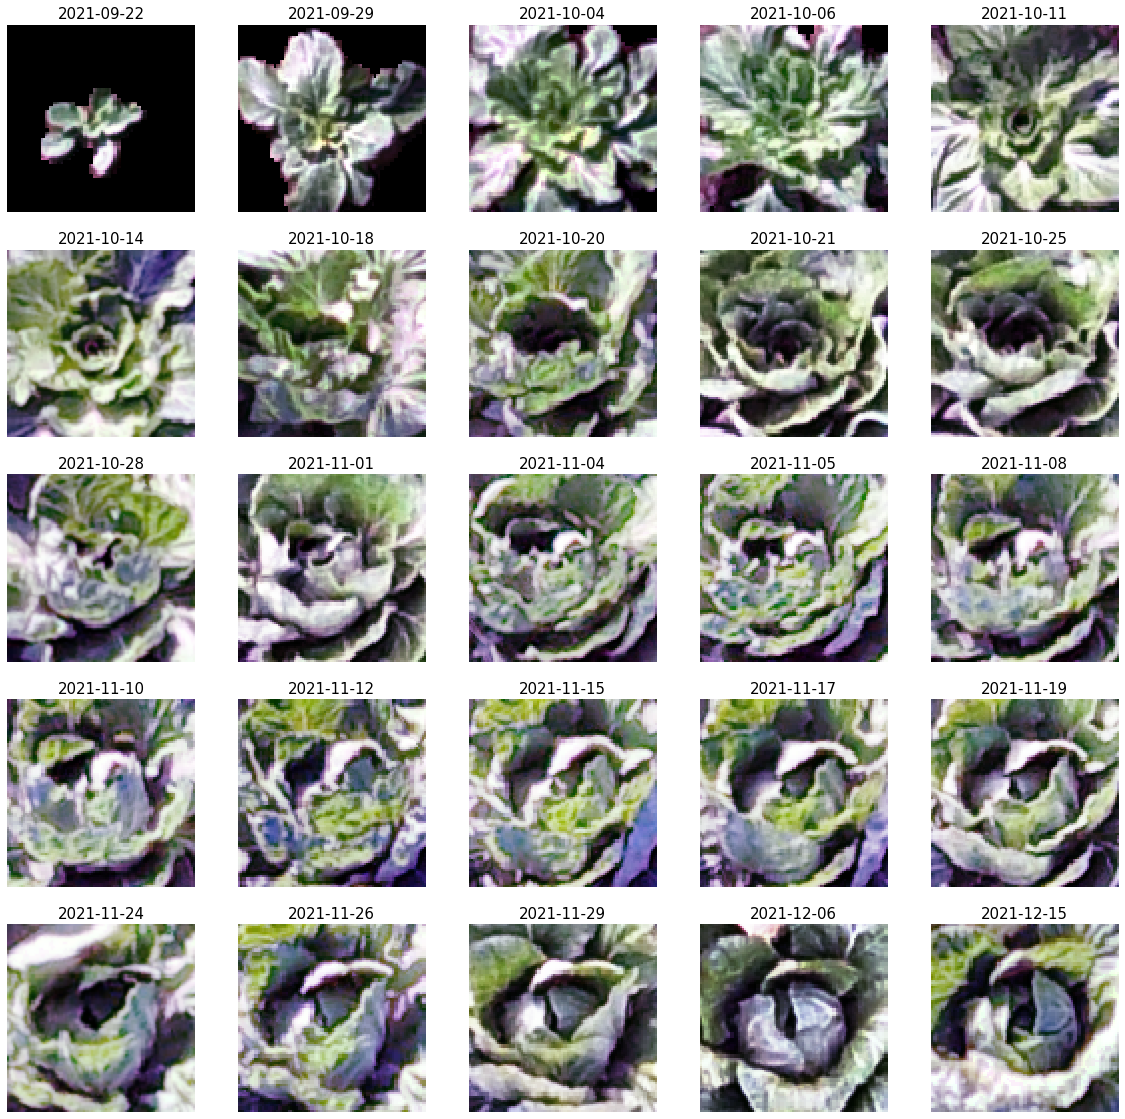

In [119]:
f= plot_multitemporal_rgb(uavdatamasked_red,ncols=5, nrows= 5, bands = ['red_eq','green_eq','blue_eq'])


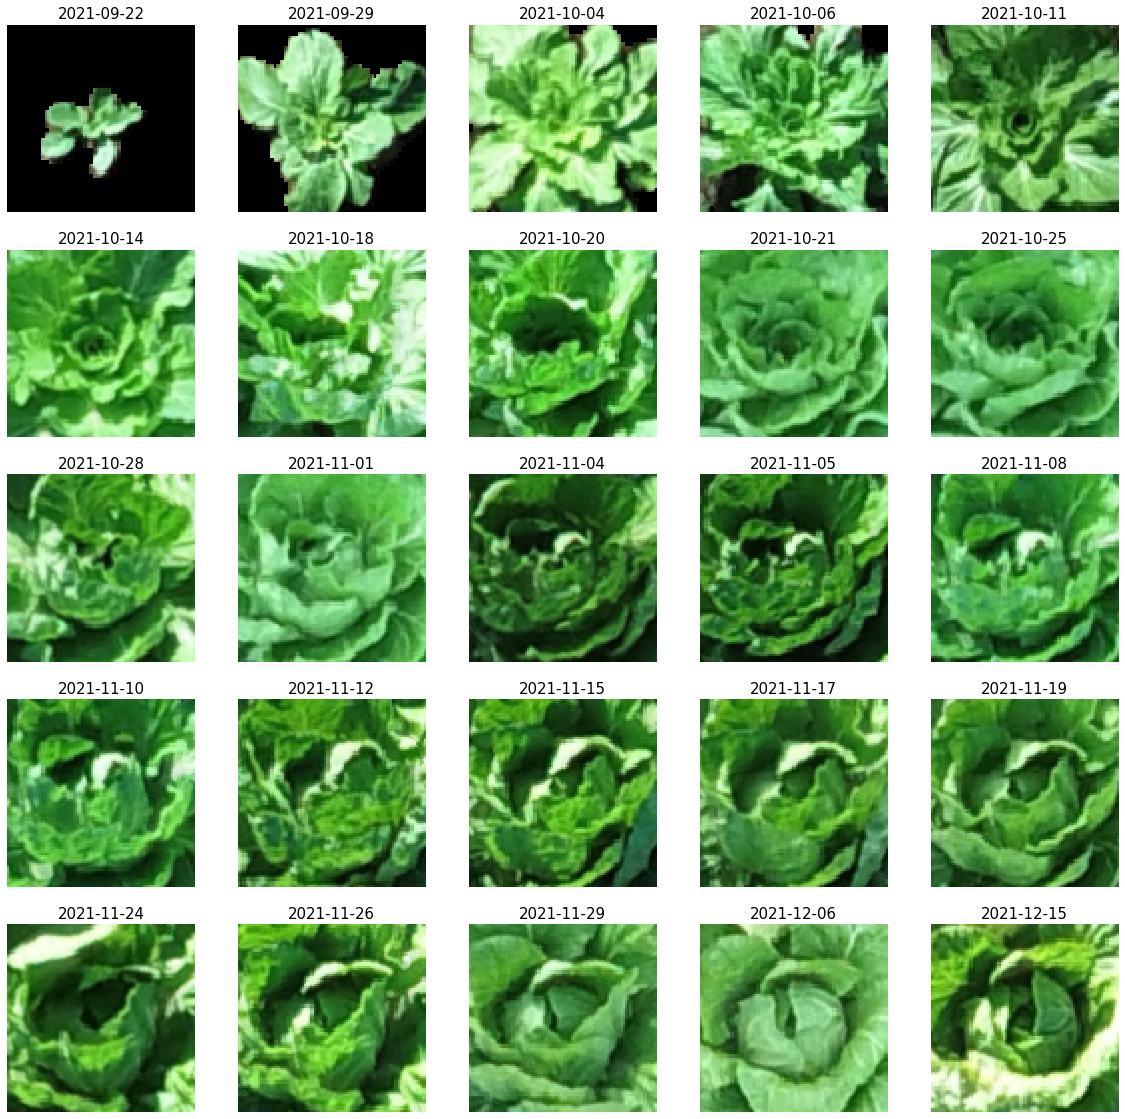

In [121]:
f= plot_multitemporal_rgb(uavdatamasked_red,ncols=5, nrows= 5)


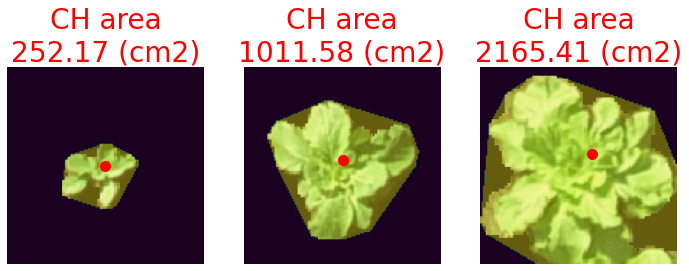

In [116]:
convplotphen.convex_hull_plot(size = 100, alphahull=0.4, figsize=(12,12))

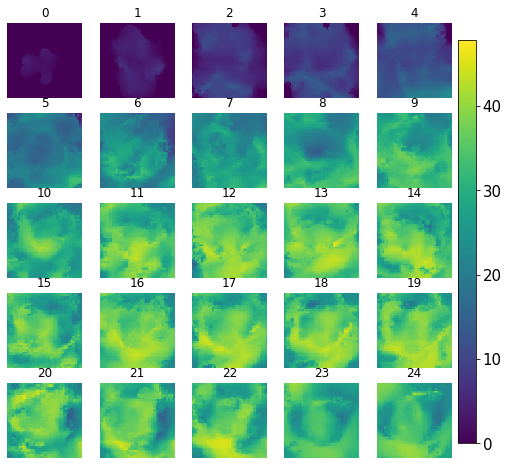

In [117]:
## leaf angle image
from drone_data.utils.plt_functions import plot_multichanels
from drone_data.utils.xyz_functions import calculate_leaf_angle

### leaf angle

f = plot_multichanels(uavdatamasked_red.z.values,num_columns= 5, num_rows=5, figsize= (8,8))


In [33]:
### summarise data
gsphenomics = Phenomics(uavdatamasked_red, filter_method= None, earlystages_filter=False)

dfph = gsphenomics.plant_height_summary(quantiles= [0.9])
dfleafangle = gsphenomics.leaf_angle_summary(quantiles= [0.5])
dfvolume = gsphenomics.volume_summary(method = 'window', reduction_perc = 100)

 ## reflectance metrics
dfreflectance = gsphenomics.splectral_reflectance(spindexes=refindexes,
                                                  quantiles= [0.5])

dfreflectance

date      value        metric
0  2021-09-22   0.000000    blue_q_0.5
1  2021-09-29  57.000000    blue_q_0.5
2  2021-10-04  86.000000    blue_q_0.5
3  2021-10-06  84.000000    blue_q_0.5
4  2021-10-11  77.000000    blue_q_0.5
..        ...        ...           ...
21 2021-11-26   0.703790  regnvi_q_0.5
22 2021-11-29   0.678470  regnvi_q_0.5
23 2021-12-06   0.607352  regnvi_q_0.5
24 2021-12-15   0.674344  regnvi_q_0.5
25 2021-12-20   0.621821  regnvi_q_0.5

[624 rows x 3 columns]

In [24]:
import pandas as pd
output  = pd.concat([dfph,
    dfleafangle,
    dfvolume,
    dfreflectance,

    ])
#id_plant_1_rgbmspointcloud.pickle
idpol = xrfile[len('id_plant_'):xrfile.index('_rgb')]
output['id_plant'] = idpol
dfconcatenated = from_long_towide(output.sort_values(by=['date']), indexname = "id_plant", values_columnname = 'value', metrics_colname='metric')


In [26]:
import geopandas as gpd
FIELDDATA = 'F:/OneDrive - The University of Tokyo/drone_data/results/tanashicropdetection/cc_od_polygons_yolodr5m_tana_ov_65conf_mn_tp.shp'
FILESUFFIX = 'pol'
ID_COLNAME = "id_plant"
field_data = gpd.read_file(FIELDDATA)

field_data[ID_COLNAME]  = field_data[ID_COLNAME].values

pd.merge(field_data, dfconcatenated, how="left", on=[ID_COLNAME])

pred      score    id  id_plant  id_pol cultivar_x  total_w_x  ball_w_x  \
0        0  87.550056     0         3       0         F2      500.0     295.0   
1        1  87.934111     1        46       1         F2      540.0     255.0   
2        2  86.076533     2         1       2         P1      285.0     160.0   
3        3  84.188400     3        47       3         F2      305.0     155.0   
4        4  83.141389     4        45       4         P2      325.0     190.0   
...    ...        ...   ...       ...     ...        ...        ...       ...   
1149    11  68.290000  1163        91    1149         F2      165.0     105.0   
1150     8  67.904000  1166        44    1150         P1      135.0       NaN   
1151    12  72.158500  1168       455    1151         F2      120.0      55.0   
1152    11  72.466667  1169       516    1152         F2      122.0       NaN   
1153     5  68.001000  1171  22_first    1153         F2        NaN       NaN   

      tpbeforecu  tpaftercut  ... z_q_0.9_t23  z_q_0.9_t24  z_q_0.9_t25  \
0            0.0         0.0  ...         NaN          NaN          NaN   
1            0.0         0.0  ...         NaN          NaN          NaN   
2            0.0         0.0  ...    40.44322    39.689114    37.500126   
3            0.0         0.0  ...         NaN          NaN          NaN   
4            3.0         2.0  ...         NaN          NaN          NaN   
...          ...         ...  ...         ...          ...          ...   
1149         0.0         0.0  ...         NaN          NaN          NaN   
1150         0.0         0.0  ...         NaN          NaN          NaN   
1151         0.0         0.0  ...         NaN          NaN          NaN   
1152         0.0         0.0  ...         NaN          NaN          NaN   
1153         0.0         0.0  ...         NaN          NaN          NaN   

      z_q_0.9_t3  z_q_0.9_t4 z_q_0.9_t5  z_q_0.9_t6  z_q_0.9_t7  z_q_0.9_t8  \
0            NaN         NaN        NaN         NaN         NaN         NaN   
1            NaN         NaN        NaN         NaN         NaN         NaN   
2      11.104349   18.693208  22.958739   28.218296   29.182581    32.49148   
3            NaN         NaN        NaN         NaN         NaN         NaN   
4            NaN         NaN        NaN         NaN         NaN         NaN   
...          ...         ...        ...         ...         ...         ...   
1149         NaN         NaN        NaN         NaN         NaN         NaN   
1150         NaN         NaN        NaN         NaN         NaN         NaN   
1151         NaN         NaN        NaN         NaN         NaN         NaN   
1152         NaN         NaN        NaN         NaN         NaN         NaN   
1153         NaN         NaN        NaN         NaN         NaN         NaN   

      z_q_0.9_t9  
0            NaN  
1            NaN  
2      35.390937  
3            NaN  
4            NaN  
...          ...  
1149         NaN  
1150         NaN  
1151         NaN  
1152         NaN  
1153         NaN  

[1154 rows x 719 columns]

In [21]:
import numpy as np
widephenomycs = []
for name in np.unique(output.metric.values):
    print(name)
    ssdata = output.loc[output.metric == name]

    ssdatawide = ssdata.copy().reset_index()
    ssdatawide['idx'] = ssdatawide.sort_values(by=['date']).groupby(['id_plant']).cumcount()
    ssdatawide['idx'] = np.unique(ssdatawide.metric.values) + '_t' + ssdatawide.idx.astype(str)
    
    widephenomycs.append(ssdatawide.pivot(
       index='id_plant',columns='idx',values='value').reset_index())

blue_eq_q_0.5
blue_ms_q_0.5
blue_q_0.5
edge_q_0.5
gndvi_q_0.5
green_eq_q_0.5
green_ms_q_0.5
green_q_0.5
grvi_q_0.5
grvi_rgb_q_0.5
leaf_angle_q_0.5
mgrvi_q_0.5
mgrvi_rgb_q_0.5
ndre_q_0.5
ndvi_q_0.5
negvi_q_0.5
nir_q_0.5
reci_q_0.5
red_eq_q_0.5
red_ms_q_0.5
red_q_0.5
regnvi_q_0.5
rgbvi_q_0.5
rgbvi_rgb_q_0.5
savi_q_0.5
volume
z_q_0.9
